Andy Nguyen, Michael Wolfe, Spencer Fogelman, Joseph Caguioa

DS 7331-407

Thursday 6:30 - 8:00 PM

<center><h1>Lab 3: Cluster Analysis of AirBnb listings in major U.S. cities</h1></center>

<a id='top'></a>
# Rubric / Table of Contents

* [Business Understanding 1](#business_understanding) (10 pts)
* [Data Understanding 1](#data_understanding_1) (10 pts)
* [Data Understanding 2](#data_understanding_2) (10 pts)
* [Modeling and Evaluation 1](#modeling_evaluation_1) (10 pts)
* [Modeling and Evaluation 2](#modeling_evaluation_2) (10 pts)
* [Modeling and Evaluation 3](#modeling_evaluation_3) (10 pts)
* [Modeling and Evaluation 4](#modeling_evaluation_4) (20 pts)
* [Deployment](#deployment) (10 pts)
* [Exceptional Work](#exceptional_work) (10 pts)

## Introduction

*Dataset Source: https://www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml*

This Kaggle dataset contains data on AirBnb listings for 6 major U.S. cities (CHI, DC, LA, NYC, SF, BOS). The competition's original objective was to use the provided attributes to predict the price of a listing. However, the dataset can be adjusted to predict other variables as well.

In this notebook, we will use the data on these AirBnb listings to practice clustering algorithms to extract new features from the available data. We will use these new features to build new classifiers and assess any improvements in performance compared to the classification models in our previous notebook.

### Setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import csv
import matplotlib.pyplot as plt
#import plotly.graph_objects as go
import warnings

#from plotnine import *
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
def EncodeCategory(col_to_encode):
    distinct_cats = col_to_encode.unique()
    encode_list = []
    i = 1
    for cat in distinct_cats:
        encode_list.append([cat,i])    
        i += 1
    return(encode_list)

### Data Preparation

In [4]:
# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/anguyen-07/DS7331-ML_Labs/master/data/airbnb_train.csv')

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [6]:
df['price'] = np.exp(df['log_price'])
df['grade'] = pd.cut(df.review_scores_rating, [0,60,70,80,90,101], right=False, labels = ['F', 'D', 'C', 'B', 'A'])
df[['grade', 'review_scores_rating']].head()

,grade,review_scores_rating
0,A,100.0
1,A,93.0
2,A,92.0
3,NaN,NaN
4,F,40.0


In [7]:
# Clean up datatypes and duplicates
df_ratings = df.dropna(subset=['review_scores_rating'])
df_ratings.drop_duplicates(inplace=True)
floats = ['log_price','bathrooms','latitude','longitude','review_scores_rating', 'price']
df_ratings[floats] = df_ratings[floats].astype(np.float64)
ints = ['id','accommodates','number_of_reviews','bedrooms','beds']
df_ratings["host_response_rate"] = df_ratings["host_response_rate"].str.rstrip('%').astype(np.float64)/100
date_time = ['first_review','host_since','last_review']
df_ratings[date_time] = df_ratings[date_time].apply(pd.to_datetime)
booleans = ['host_has_profile_pic','host_identity_verified','instant_bookable']
df_ratings[booleans] = df_ratings[booleans].replace({'t':True,'f':False})
df_ratings[booleans] = df_ratings[booleans].astype(np.bool)
categorical = ['property_type','room_type','bed_type','cancellation_policy','city','neighbourhood','zipcode']
df_ratings[categorical] = df_ratings[categorical].astype('category')
df_ratings.drop_duplicates()
df_ratings.host_since[df_ratings.host_since.isna()] = df_ratings.first_review[df_ratings.host_since.isna()]

In [8]:
# Impute missing values
df_imputed = df_ratings
df_imputed["bathrooms"] = df_imputed["bathrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bathrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["bedrooms"] = df_imputed["bedrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bedrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["beds"] = df_imputed["beds"].fillna(df_imputed.groupby(["property_type","accommodates"])["beds"].apply(lambda x : x.fillna(x.median())))
df_imputed["host_response_rate"] = df_imputed["host_response_rate"].fillna(df_imputed.groupby(["number_of_reviews"])["host_response_rate"].apply(lambda x : x.fillna(x.mean())))
df_imputed[ints] = df_imputed[ints].astype(np.int64)
df_imputed = df_imputed.dropna()

In [9]:
import re
#Create a new cleaned amenities column where all amenities are in list form
df_imputed['amenities_new'] = df_imputed.apply(lambda row: re.sub(r'[{}""]', '', row['amenities']), axis=1)
df_imputed['amenities_new'] = df_imputed.apply(lambda row: row['amenities_new'].lower().split(','), axis=1)
df_imputed = df_imputed.reset_index()
df_imputed['length_amenities'] = df_imputed.apply(lambda row: len(row['amenities_new']), axis=1)

# Create separate columns based on amenities
df_imputed['internet'] = df_imputed.apply(lambda row: 'internet' in row.amenities.lower(), axis=1)
df_imputed['TV'] = df_imputed.apply(lambda row: 'tv' in row.amenities.lower(), axis=1)
df_imputed['air_conditioning'] = df_imputed.apply(lambda row: 'air conditioning' in row.amenities.lower(), axis=1)
df_imputed['kitchen'] = df_imputed.apply(lambda row: 'kitchen' in row.amenities.lower(), axis=1)
df_imputed['pool'] = df_imputed.apply(lambda row: 'pool' in row.amenities.lower(), axis=1)
df_imputed['parking'] = df_imputed.apply(lambda row: 'parking' in row.amenities.lower(), axis=1)

# Get information from description based on length in characters
df_imputed['description_length'] = df_imputed['description'].apply(len)

# Create the target variable superuser
df_imputed['superuser'] = False
df_imputed.loc[df.review_scores_rating >=96, 'superuser'] = True

# Create altnerative target variable grade_grouped
new_grades = {
    'A':'A',
    'B':'<A',
    'C':'<A',
    'D':'<A',
    'F':'<A'
}
df_imputed['grade_grouped'] = df_imputed['grade'].map(new_grades)

In [10]:
import datetime
date_published = datetime.datetime(2018,3,14)
df_imputed['host_since'] = pd.to_datetime(df_imputed['host_since'])
df_imputed['host_since_days'] = df_imputed.apply(lambda row: (date_published - row['host_since']).days, axis=1)

**Removed columns that are not meaningful in a modeling context (i.e., index,id), redundant with newly engineered features (i.e., amenities, description), or are likenly not useful in predicting the target variable grade_grouped.**

In [11]:
# delete useless columns
df_logistic = df_imputed.drop(['index','id','amenities','description','zipcode','description_length',
                               'latitude','longitude','name','neighbourhood','review_scores_rating','thumbnail_url',
                               'zipcode'], axis=1)

# delete other redundant variables
del df_logistic['amenities_new']
del df_logistic['host_since']
# del df_logistic['grade']
del df_logistic['first_review']
del df_logistic['last_review']

# Remove factor with unncessarily large number of levels
df_logistic.drop(['property_type'], axis=1, inplace=True)

**One-Hot Encode Categorical Variables with multiple levels.**

In [12]:
categorical_vars = ['room_type','bed_type','cancellation_policy','city']

# Create Dummy Variables
multiCategorical_vars = ['city','cancellation_policy','bed_type','room_type']

dummy_df = pd.get_dummies(df_logistic[multiCategorical_vars], drop_first = True)
df_final = pd.concat([df_logistic, dummy_df], axis=1)
del df_final['grade']

# Delete non-dummy categorical variables
for x in categorical_vars:
    if x in df_final:
        del df_final[x]

In [13]:
#df_final = df_final.loc[df_imputed['grade'] == 'A'].reset_index()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46759 entries, 0 to 46758
Data columns (total 37 columns):
log_price                              46759 non-null float64
accommodates                           46759 non-null int64
bathrooms                              46759 non-null float64
cleaning_fee                           46759 non-null bool
host_has_profile_pic                   46759 non-null bool
host_identity_verified                 46759 non-null bool
host_response_rate                     46759 non-null float64
instant_bookable                       46759 non-null bool
number_of_reviews                      46759 non-null int64
bedrooms                               46759 non-null int64
beds                                   46759 non-null int64
price                                  46759 non-null float64
length_amenities                       46759 non-null int64
internet                               46759 non-null bool
TV                                     46759 non

## <a id='business_understanding'>Business Understanding</a> (10 pts)
[Return to top](#top)

<i><span style='color:gray'>
Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effective of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?
</span></i>

In [14]:
df_final.describe()

,log_price,accommodates,bathrooms,host_response_rate,number_of_reviews,bedrooms,beds,price,length_amenities,host_since_days,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Private room,room_type_Shared room
count,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000,46759.000000
mean,4.741537,3.129002,1.202325,0.957378,28.546333,1.232533,1.700913,144.885562,18.407964,1378.782395,0.049210,0.059817,0.241900,0.493466,0.097885,0.291730,0.479180,0.000749,0.000128,0.002802,0.011442,0.008982,0.970573,0.416690,0.024124
std,0.652371,2.045621,0.530329,0.109481,42.850931,0.811593,1.226919,128.413394,6.994321,668.929673,0.216308,0.237151,0.428239,0.499963,0.297162,0.454564,0.499572,0.027349,0.011327,0.052857,0.106353,0.094349,0.169003,0.493016,0.153435
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,167.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.304065,2.000000,1.000000,0.946121,4.000000,1.000000,1.000000,74.000000,14.000000,852.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,4.700480,2.000000,1.000000,1.000000,12.000000,1.000000,1.000000,110.000000,18.000000,1324.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,5.164786,4.000000,1.000000,1.000000,35.000000,1.000000,2.000000,175.000000,22.000000,1856.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,7.600402,16.000000,8.000000,1.000000,542.000000,10.000000,18.000000,1999.000000,77.000000,3663.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


This data is provided through Kaggle with the objective to predict the price of AirBnb listings in major cities in the United States. Each record in the original dataset is one AirBnB listing from 2018 with 29 attributes that describe the listing and what it offers to guests. 

A model predicting listing price could be extremely beneficial for new AirBnb hosts to guide them in setting an initial price for their listings based on location, amenities, and other features that they offered with their listing. Furthermore, the price perdiction model could help ensure that AirBnb guests are not overcharged for their stay and that hosts are adequately compensated for their hospitality. The performance of this model would be measured by the root mean square error (RMSE) to determine how far predictions deviate from actual values. Using the RMSE metric is most appropriate within this context because it heavily penalizes large errors and we want to avoid significant prediction errors in listing prices.  

In our previous analyses, we investigated the review scores rating to better understand which features of an AirBnb listing influence a higher score using a binary classification model. The goal was to differentiate between listings with an average review score rating below a 90% from listings with a rating above a 90%. With this classification model, we sought to provide valuable insight into how AirBnB hosts could improve their hospitality standards and better market their listings by increasing their listings average rating in order to become eligible for Superhost status.

In this analysis, we will cluster a subset of our dataset's features using different clustering algorithms and evaluate which of our clusters is the best using the elbow method with inertia for k-means, and k-neighbors for DBSCAN. We will then replace those old subsetted features with new labels from our best clusters and build a classifier using these newly clustered features. Our goal is to investigate if this new classifier performs better than our previous classification model in a random forest algorithm.

We will use precision to evaluate our classification model with grade-grouped as the target variable since there is a large majority for the class with a 90% or higher for the review scores rating. With an abundance of instances for this class, we want to miniize the false positives in order to determine which hosts have Superhost potential. We may also want to evaluate the classifier with the F-measure to minimize the false negative predictions as well since we do not want to miss out on any hosts that could potentially benefit from the Superhost program. In other words, we seek to penalize the misclassification of listings with a rating lower than 90% much more than the misclassification of listings with a rating 90% or higher.

Finally, we will use a Stratified 5-Fold cross validation method to evaluate our two classification models on the precision/F-measure metrics since our classes are heavily imbalanced. We will only use 5 folds since we believe the size of our dataset is sufficient and to avoid unnecessarily long run times.


**NOTE: The Superhost program requires listings to meet certain benchmarks before becoming eligible; such as 4.8/5 star rating, a 90% response rate, <1% cancellation rate, and a minimum of 10 guest stays.**

***

## <a id='data_understanding_1'>Data Understanding 1</a> (10 pts)
[Return to top](#top)

<i><span style='color:gray'>
Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?
</span></i>

This dataset originally contained 74,111 records and 29 columns. After we cleaned the data to remove attributes that contained repetitive information, imputed missing values to improve the data quality, and one hot encoded our categorical variables multiples levels, our final dataset contains 57,389 records and 37 columns. 

#### Data Types for Attributes of the Original Dataset

| Attribute | Measurement Scale | Data Type | Description | %_DataMissing |
| :-------: | :---------------: | :-------: | :---------: | :-----------: | 
| id |  Nominal | int64 | Unique Identifier for listing | 0% |
| log_price | Interval | float64 | natural logarithm of the listing price | 0% |
| property_type | Nominal | object | The listing's property type (i.e. House, Apartment, Condominium, etc.) | 0% |
| room_type | Nominal | object | The type of room provided by the listing (i.e. Private Room, Entire home/apt, etc.) | 0% |
| amenities | Nominal | object | Amenities the listing provides (i.e. TV, WIFI, A/C, Parking, Kitchen, etc.) | 0% |
| accommodates | Interval | int64 | Number of guests the listing can accommodate | 0% |
| bathrooms | Interval | float64 | Number of bathrooms the listing provides |
| bed_type | Nominal | object | The type of beds the listing provides (i.e. Real Bed, Air Mattress, Futon, etc.) | 0.3% |
| cancellation_policy | Ordinal | object | Level of cancellation policy regarding refunds for reservations at the listing (i.e. flexible, moderate, strict) | 0% |
| cleaning_fee | Nominal | bool | Does the listing charge a cleaning fee? (i.e. True or False) | 0% |
| city | Nominal | object | The United States city where the listing is located | 
| description | Nominal | object | A description of the listing provided by the host | 0% |
| first_review | Ordinal | datetime | The date of the listing's first review (e.g. 2017-01-01) | 21% |
| host_has_profile_pic | Nominal | bool | Does the listing's host provide a profile picture? (i.e. True or False) | 0.3% |
| host_identity_verified | Nominal | bool | Has the listing's host verified their identification with AirBnb? (i.e. True or False) | 0.3% |
| host_response_rate | Ratio | float64 | Host's response rate to all guest inquiries (i.e. 0-100%) |  25% |
| host_since | Ordinal | datetime | Date when host first listed their property with Airbnb (e.g. 2017-01-01) | 0.3% | 
| instant_bookable | Nominal | bool | Can the listing be instantly booked (i.e. True or False) | 0% |
| last_review | Ordinal | datetime | Date of the listing's last review from an AirBnb guest | 21% |
| latitude | Interval | float64 | Latitude Coordinates of the listing | 0% | 
| longitude | Interval | float64| Longitude Coordinates of the listing | 0% |
| name | Nominal | object | The name identifying the listing in AirBnb property searches | 0% |
| neighbourhood | Nominal | object | The neighborhood in the United States where the listing is located | 9% |
| number_of_reviews | Interval | int64 | The number of reviews the listing has received from previous guests | 0% |
| review_scores_rating | Ratio | float64 | The AirBnB rating score compiled from all the listing's reviews | 23 % |
| thumbnail_url | Nominal | object | The thumbnail url associated with the listing | 11% |
| zipcode | Nominal | object | The United States zipcode where the listing is located in | 1.3% |
| bedrooms | Interval | int64 | The number of bedrooms the listing provides |  0.1% |
| beds | Interval | int64 | The number of beds the listing provides | 0.2% |
| grade | Ordinal | category | The grade assigned to the listing based on its reviews rating score | 23% |
| price | Ratio | float64 | The listing's price in U.S. dollars ($) | 0% |

We removed all listings with missing values for the review_scores_rating field because our target variable is based off the 90% cutoff value for this variable. 

As shown in the table above, there are a few fields in the dataset that have missing values we believe may have resulted from data entry errors. We imputed those missing values with either the median or mean depending on the attribute following these guidelines:
<br>

**Impute Missing Values for Bathrooms with median values based on Property Type & Accomodates**
* 159 missing values for bathrooms
    * Impute Apartments accommodating (1-5) w/ 1 bathroom (100 values)
    * Impute Bed & Breakfast accommodating (1-2) w/ 1 bathroom (3 values)
    * Impute Camper/RV accomodating 2 w/ 1 bathroom (1 value)
    * Impute Dorm accomodating (1-2) w/ 1 bathroom (8 values)
    * Impute House accomodating (1-4) w/ 1 bathroom (39 values)
    * Impute House accomodating 6 w/ 2 bathrooms (1 value)
    * Impute House accomodating 8 w/ 2.5 bathrooms (1 value)
    * Impute House accomodating 16 w/ 3 bathrooms (1 value)
    * Impute Loft accomodating 2 w/ 1 bathroom (1 value)
    * Impute Other accomodating (2-4) w/ 1 bathroom (4 values)
<br>

**Impute Missing Values for Bedrooms with median values based on Property Type & Accomodates**
* 70 missing values for bedrooms
    * Impute Apartments accomodating (1-4) w/ 1 bedroom (57 values)
    * Impute Bungalow accomodating 3 w/ 1 bedroom (1 value)
    * Impute House accomodating 2 w/ 1 bedroom (7 values)
    * Impute House accomodating 6 w/ 3 bedroom (1 value)
    * Impute Loft accomodating 4 w/ 1 bedroom (3 values)
    * Impute Other accomodating 1 w/ 1 bedroom (1 value)
<br>

**Impute Missing Values for Beds with median values based on Property Type & Accomodates**
* 62 missing values for beds
    * Impute Apartments accomodating (1-3) w/ 1 bed (38 values)
    * Impute Apartments accomoodating 4 w/ 2 beds (1 value)
    * Impute Condominium accomodating 2 w/ 1 bed (1 value)
    * Impute Dorm accomodating 1 w/ 1 bed (1 value)
    * Impute Guesthouse accomodating 1 w/ 1 bed (1 value)
    * Impute House accomodating (1-2) w/ 1 bed (14 values)
    * Impute House accomodating 3 w/ 2 beds (1 values)
    * Impute House accomodating 5 w/ 3 beds (1 value)
    * Impute House accomodating 16 w/ 8 beds (1 value)
    * Impute Other accomodating (1-2) w/ 1 bed (2 values)
    * Impute Townhouse accomodating 2 w/ 1 bed (1 value)
<br>

**Impute Missing Values of host_response_rate Variable with mean value based on number of reviews and host response rate**
* 26,107 missing values for host_response_rate
<br>

We found no duplicated instances in our dataset, but did find an outlier data point for log_price with a value of 0. This expression results in an undefined value and does not make sense within the context of a price range. We will proceed by dropping this instance from our dataset.

In [15]:
# Instance 8968 inside the dataset
df_final[df_final["log_price"] == 0]

,log_price,accommodates,bathrooms,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,number_of_reviews,bedrooms,beds,price,length_amenities,internet,TV,air_conditioning,kitchen,pool,parking,superuser,grade_grouped,host_since_days,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Private room,room_type_Shared room
7302,0.0,1,1.0,True,True,False,1.0,True,3,1,1,1.0,12,True,True,True,True,False,False,True,<A,237,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1


After dropping that instance, our final dataset that will be used to perform cluster analysis and model building contains 57,388 records and 38 attributes. There are more columns in this cleaned version despite the removal of irrelevant and highly correlated attributes due to our One-Hot Encoding of the categorical variables with multiple levels.

We also created new features that were extracted from the original amenities field that contained a list of the amenities that the AirBnb listing provided. We thought that internet, TV, air_conditioning, kitchen, pool, and parking amenities would be important factors that influence rating so we created each as a new binary variable in our dataset.

Our logic behind the methods in which we cleaned our dataset to remove instances/attributes, impute missing values, and create new features can be found in the Data Preparation section.

In [16]:
df_final = df_final[df_final["log_price"] > 0].reset_index()
df_final = df_final.drop(["index", "price"], axis=1)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46758 entries, 0 to 46757
Data columns (total 36 columns):
log_price                              46758 non-null float64
accommodates                           46758 non-null int64
bathrooms                              46758 non-null float64
cleaning_fee                           46758 non-null bool
host_has_profile_pic                   46758 non-null bool
host_identity_verified                 46758 non-null bool
host_response_rate                     46758 non-null float64
instant_bookable                       46758 non-null bool
number_of_reviews                      46758 non-null int64
bedrooms                               46758 non-null int64
beds                                   46758 non-null int64
length_amenities                       46758 non-null int64
internet                               46758 non-null bool
TV                                     46758 non-null bool
air_conditioning                       46758 non-nu

As shown in the violin plot below, the removal of the instance with a log_price of 0 results in an even distribution for the AirBnb listings in each of the major U.S. cities (Boston, Chicago, D.C., Los Angeles, New York, San Francisco) without the presence of any glaring outliers.

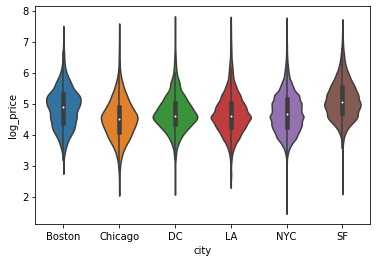

In [17]:
sns.violinplot(x="city", y="log_price", data = df_logistic[df_logistic["log_price"] > 0])

***

## <a id='data_understanding_2'>Data Understanding 2</a> (10 pts)
[Return to top](#top)

<i><span style='color:gray'>
Visualize any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.
</span></i>

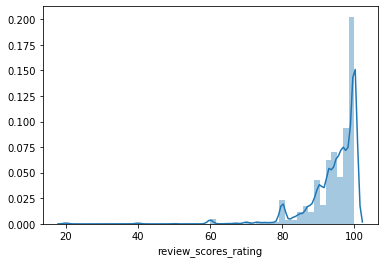

In [18]:
# df_imputed is the dataset before dropping redundant variables
df_imputed = df_imputed[df_imputed["log_price"] > 0].reset_index()
sns.distplot(df_imputed["review_scores_rating"])

The bulk of the listing review score averages are concentrated between 80 and 100, which corresponds to an average of 4-5 stars. By default, most guests will usually leave perfect (5-star) ratings unless they have significant problems with their experience. Hence, most listings will maintain a decent score.

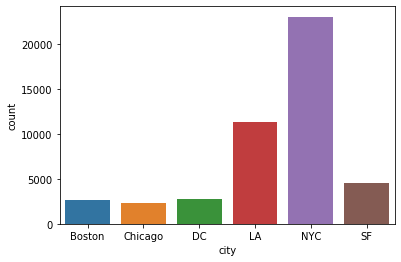

In [19]:
# Bar Graph for Frequency by City
# df_logistic is the dataset before One-Hot Encoding
df_logistic = df_logistic[df_logistic["log_price"] > 0].reset_index()
sns.countplot(x="city", data=df_logistic)

Most of the listings in this dataset come from either New York City or Los Angeles. In total, only six cities are represented in the original dataset, and all of them are major metropolitan areas.

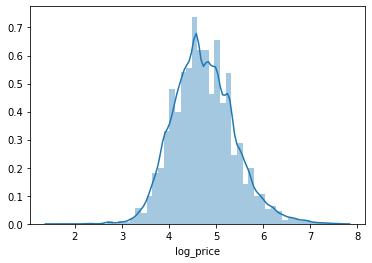

In [20]:
# Histogram for Natural Log of Price
sns.distplot(df_final["log_price"])

The logged price variable, the target for the original Kaggle problem where the objective was to predict listing price, appears normally distributed.

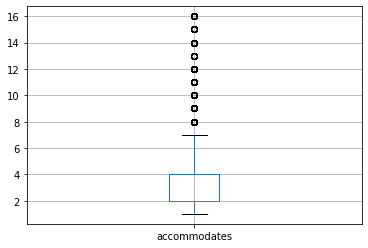

In [21]:
df_final.boxplot(column="accommodates")

The number of guests an average listing can accommodate likely lies between 1 and 7, with some outlier properties able to accommodate even more. This variable is correlated with the numbers of bedrooms, beds, and bathrooms, as all of those are directly linked to how many extra people a property can feasibly and comfortably accommodate.

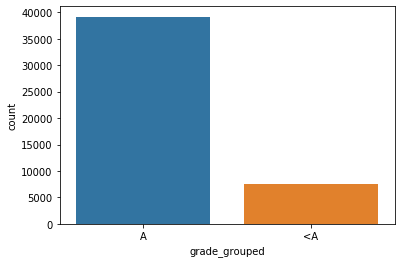

In [22]:
sns.countplot(df_final["grade_grouped"])

Review scores have been mapped to a simplified, grouped scale of academic grades, where a 90 or better is an A and anything less is <A. Because most guests will leave 5-star reviews unless there are issues, most listings carry average review score ratings in the high 4- to 5-star range, which translates to most listings having an A.

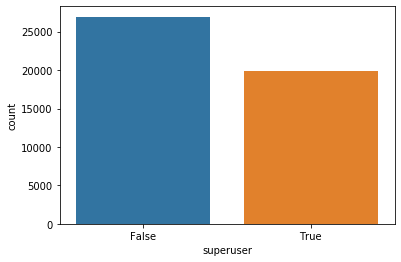

In [23]:
sns.countplot(df_final["superuser"])

In contrast to the A and <A threshold, the average grade required for Airbnb Superhost status is more stringent--the 4.8 overall rating translates to a 96 on a 100-point scale. Due to this, the distribution between Superhost and not is more even than that between A and <A.

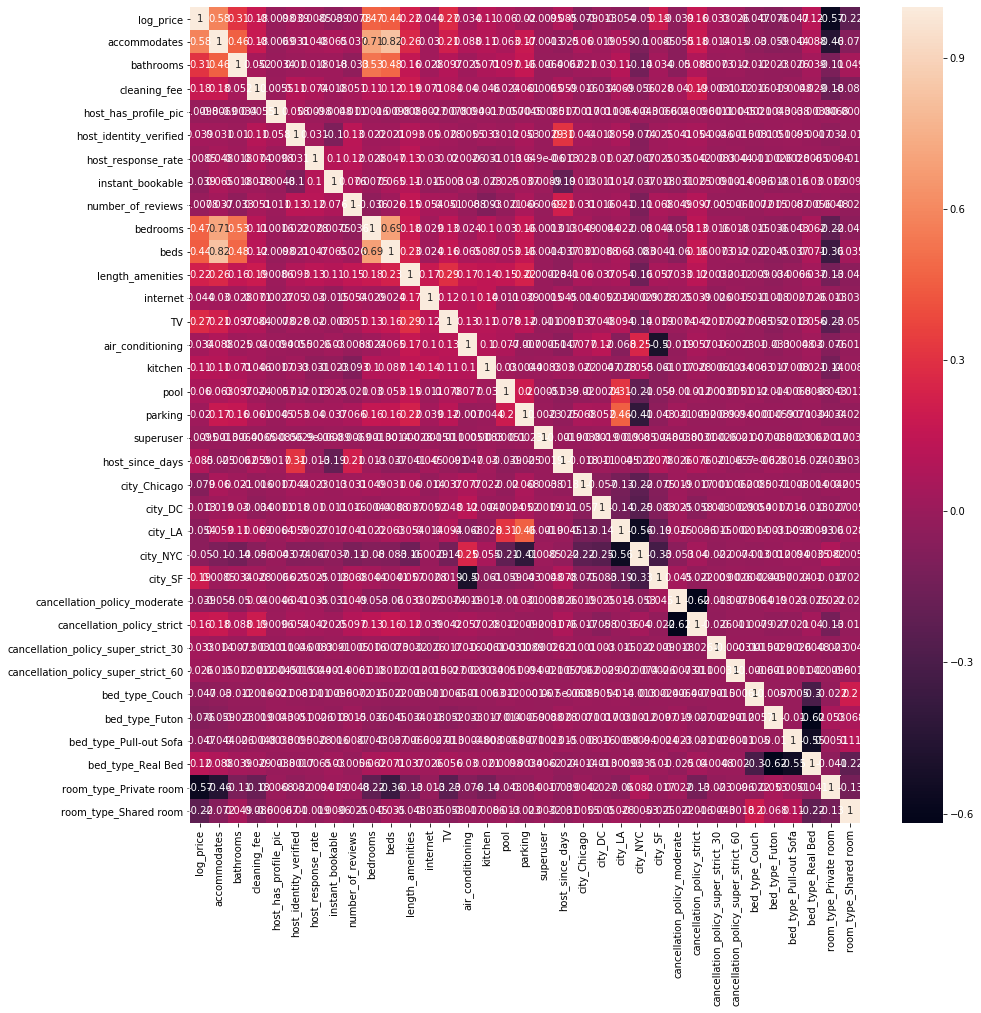

In [24]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,15)) 
corr = df_final.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True,
           ax=ax)

The above heatmap compares the correlations between numeric and boolean variables in our dataset. As previously suggested, variables associated with the number of guests a listing can comfortably handle--accommodates, bathrooms, bedrooms, and beds--are positively correlated with each other. 

Some other interesting information can be gleamed about individual cities in the dataset, such as negative correlations between San Francisco and the presence of air conditioning, or New York City and onsite parking. Conversely, Los Angeles listings seem to have positive correlations with pools and parking.

***

## Modeling and Evaluation

<i><span style='color:gray'>
Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results.

**Cluster Analysis**
* Perform cluster analysis using several clustering methods
* How did you determine a suitable number of clusters for each method?
* Use internal and/or external validation measures to describe and compare the clusterings and the clusters (some visual methods would be good.)
* Describe your results. What findings are the most interesting and why?
</span></i>

### Baseline Classification Performance

In [25]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

y_base = df_final['grade_grouped']
# Removed superuser from target variable since it contains data that is highly correlated with grade_grouped target variable
X_base = df_final.drop(['grade_grouped','superuser'], axis = 1)
cv = StratifiedKFold(n_splits = 5, random_state = 0)

clf = RandomForestClassifier(n_estimators = 150, max_depth = None, criterion = "gini", random_state = 0)

acc = cross_val_score(clf, X = X_base, y = y_base, cv = cv)
precision = cross_val_score(clf, X = X_base, y = y_base, cv = cv, scoring = "precision_macro")
recall = cross_val_score(clf, X = X_base, y = y_base, cv = cv, scoring = "recall_macro")
f_measure = cross_val_score(clf, X = X_base, y = y_base, cv = cv, scoring = "f1_macro")

print("Average accuracy = ", acc.mean()*100, "+-", precision.std()*100)
print("Average precision = ", precision.mean()*100, "+-", precision.std()*100)
print("Average recall = ", recall.mean()*100, "+-", recall.std()*100)
print("Average f-measure = ", f_measure.mean()*100, "+-", f_measure.std()*100)


Average accuracy =  84.23586318577513 +- 1.723570305796336
Average precision =  73.51986786601596 +- 1.723570305796336
Average recall =  53.03779224232849 +- 0.4881014113114852
Average f-measure =  51.85255907060103 +- 0.8754901027185806


The parameters for the baseline classification model we chose were based off the parameters that resulted in the best performning model from our previous classification analysis of the grade_grouped target variable.

As the metrics show, our model performs decently well in accurately predicting if a listing will have either a rating grade of A or lower at 84%. The precision of our model in accurately identifying listhings with an A rating or higher is 73%, which is sufficient considering we want to penalize false positive misclassifications of lower rated listings more. However, it is important to note that since the majority of our data consists of listings with at least an A rating, the data naturally lends itself to a higher precision score.

The lower recall and f-measure scores reinforces our previous comment since it appears that our classification model does not do a great job of actually separating listings at the rating cutoff of 90% due to the heavy class imbalance. 

When comparing this baseline model to the new classifier built with extracted features from clustering, we will use the f-measure to evaluate any improvements in model performance since it encompasses a balance of both precision and recall as well as an uneven class distribution.

## <a id='modeling_evaluation_1'>Modeling and Evaluation 1</a> (10 pts)
[Return to top](#top)

<i><span style='color:gray'>
Train and adjust parameters.
</span></i>

### KMeans, Subset of Correlated Variables

In [26]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# Cluster these attributes since they have similar information regarding number of people the listing can accommodate
# Heatmap shows that these variables were most highly correlated of all attributes in the dataset
X1 = df_final[["log_price","accommodates","bathrooms","bedrooms", "beds"]]


In [27]:
# Note: PCA is performed in this analysis to visualize the newly formed clusters in a 2-D Space

from sklearn.preprocessing import StandardScaler

PCA_DFsubset = df_final[["log_price","accommodates","bathrooms","bedrooms", "beds", "grade_grouped"]]

X_subset = PCA_DFsubset.drop(['grade_grouped'], axis = 1).values
y_subset = PCA_DFsubset.loc[:,'grade_grouped'].values

In [28]:
from sklearn.decomposition import PCA
PCA_subset = PCA(n_components=2)
PC_subset = PCA_subset.fit_transform(X_subset)
PC_DFsubset = pd.DataFrame(data = PC_subset, columns = ['PCA1', 'PCA2'])

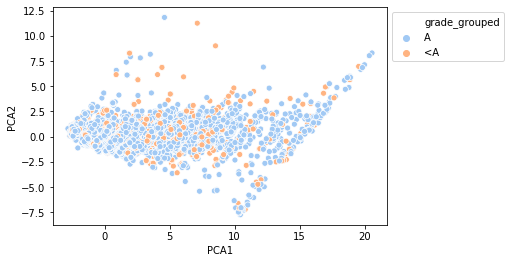

In [29]:
# Add grade_grouped into PC_DFsubset to color data points by target variable
PC_DFsubset['grade_grouped'] = PCA_DFsubset.loc[:,'grade_grouped']

sns.scatterplot(data= PC_DFsubset, x='PCA1', y='PCA2', hue='grade_grouped',
                legend='full', palette=sns.color_palette('pastel', n_colors=2))
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [30]:
PCA_subset.explained_variance_ratio_

array([0.83580877, 0.0600905 ])

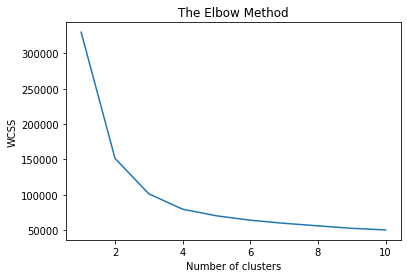

In [31]:
wcss1 = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X1)
    wcss1.append(kmeans.inertia_)
plt.plot(range(1,11),wcss1)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [32]:
kmeans_sub = KMeans(n_clusters=4,init='k-means++',max_iter=300,n_init=10,random_state=0)
clusters_sub = kmeans_sub.fit_predict(X_subset)
PC_DFsubset['clusters'] = clusters_sub

### KMeans, PCA

In [33]:
df_pca = df_imputed[['accommodates', 'bathrooms', 'host_response_rate',
             'number_of_reviews', 'bedrooms', 'beds', 'price',
            'grade', 'grade_grouped', 'description_length', 'length_amenities',
            'host_since_days', 'superuser']]

In [34]:
from sklearn.preprocessing import StandardScaler
x = df_pca.drop(['grade', 'grade_grouped', 'superuser'], axis=1).values
y = df_pca.loc[:, 'grade_grouped'].values

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PCA1', 'PCA2'])

In [36]:
target1 = df_pca.loc[:, 'grade_grouped']
principalDf['target1'] = target1
target2 = df_pca.loc[:, 'grade']
principalDf['target2'] = target2
target3 = df_pca.loc[:, 'superuser']
principalDf['target3'] = target3
target1.head()

0    A
1    A
2    A
3    A
4    A
Name: grade_grouped, dtype: object

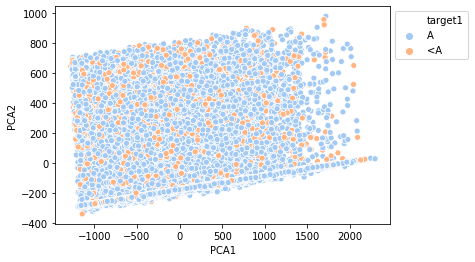

In [37]:
import seaborn as sns
sns.scatterplot(data=principalDf, x='PCA1', y='PCA2', hue='target1',
                legend='full', palette=sns.color_palette('pastel', n_colors=2))
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

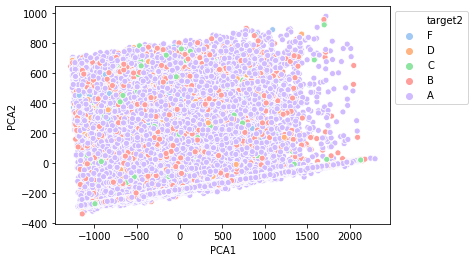

In [38]:
sns.scatterplot(data=principalDf, x='PCA1', y='PCA2', hue='target2',
                legend='full', palette=sns.color_palette('pastel', n_colors=5))
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

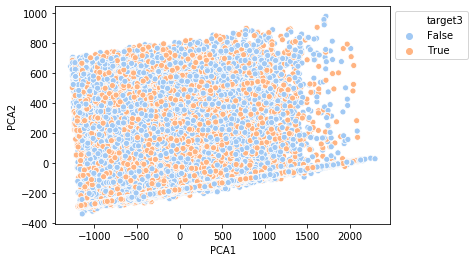

In [39]:
sns.scatterplot(data=principalDf, x='PCA1', y='PCA2', hue='target3',
                legend='full', palette=sns.color_palette('pastel', n_colors=2))
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [40]:
pca.explained_variance_ratio_

array([0.82583175, 0.14094247])

In [41]:
df_cluster = df_pca.copy()
df_cluster_x = df_pca.drop(['grade', 'grade_grouped', 'superuser'], axis=1)

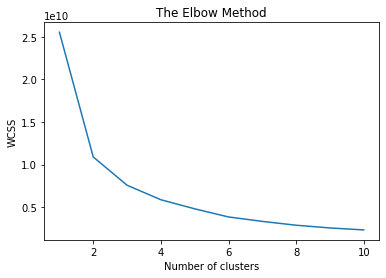

In [42]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(df_cluster_x)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

* optimal k is two

In [43]:
kmeans = KMeans(n_clusters=2,init='k-means++',max_iter=300,n_init=10,random_state=0) 
clusters = kmeans.fit_predict(df_cluster_x)
principalDf['clusters'] = clusters

### DBSCAN, Subset of Variables

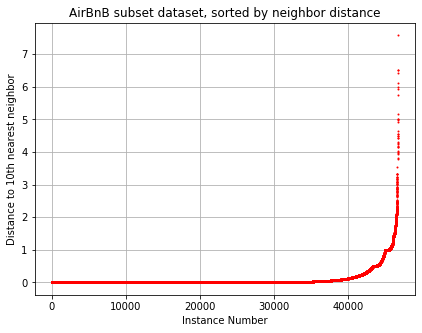

In [44]:
from sklearn.neighbors import kneighbors_graph
N = 10
knn_graph = kneighbors_graph(X1, N, mode='distance') 
N2 = knn_graph.shape[0]
X_4nn_distances = np.zeros((N2,1))
for i in range(N2):
    X_4nn_distances[i] = knn_graph[i,:].max()

X_4nn_distances = np.sort(X_4nn_distances, axis=0)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N2), X_4nn_distances, 'r.', markersize=2)
plt.title('AirBnB subset dataset, sorted by neighbor distance')
plt.xlabel('Instance Number')
plt.ylabel('Distance to {0}th nearest neighbor'.format(N))
plt.grid()

plt.show()

Optimal eps is ~25

In [45]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1, min_samples=10).fit(X1)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

db_clusters = db.fit_predict(X1)
db_clusters

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

***

## <a id='modeling_evaluation_2'>Modeling and Evaluation 2</a> (10 pts)
[Return to top](#top)

<i><span style='color:gray'>
Evaluate and compare.
</span></i>

### KMeans, Subset of Correlated Variables - Performance Testing

In [46]:
params1 = []
for i in range (1,11):
    cls1 = KMeans(n_clusters = i, init = "k-means++", random_state = 0)
    cls1.fit(X1)
    newfeatures_cls1 = cls1.labels_

    y1 = df_final['grade_grouped']
    X1 = df_final.drop(['grade_grouped','superuser'], axis = 1)
    X1 = np.column_stack((X1, pd.get_dummies(newfeatures_cls1)))

    f_measure1 = cross_val_score(clf, X = X1, y = y1, cv = cv, scoring = "f1_macro")
    params1.append((i, f_measure1.mean()*100, f_measure1.std()*100)) # save all calculated f-measures
    
    print("Clusters", i, "Average f-measure = ", f_measure1.mean()*100, "+-", f_measure1.std()*100)

Clusters 1 Average f-measure =  52.050111975624816 +- 0.8253443217793541
Clusters 2 Average f-measure =  52.26562360551672 +- 0.8388421249149357
Clusters 3 Average f-measure =  52.275696660210635 +- 0.6478542557870411
Clusters 4 Average f-measure =  52.45229947719916 +- 0.7481407623017632
Clusters 5 Average f-measure =  52.590735736403026 +- 0.7437036360416629
Clusters 6 Average f-measure =  52.24900556360418 +- 0.7560611707186055
Clusters 7 Average f-measure =  52.40433445845325 +- 0.556524672041084
Clusters 8 Average f-measure =  52.34398746778084 +- 0.919245129119359
Clusters 9 Average f-measure =  52.36701154795335 +- 0.6975240369754615
Clusters 10 Average f-measure =  52.428196347704414 +- 0.4214142057208145


* 4 clusters is optimal using k-means algorithm with mean f-measure of 52.3 and standard deviation of 0.578
    * Marginal improvement in f-measure compared to baseline, but there is a tighter distribution with a decrease of standard deviation from 0.759 to 0.578

### KMeans, PCA - Performance Testing

In [47]:
params2 = []
for i in range (1,11):
    cls2 = KMeans(n_clusters = i, init = "k-means++", random_state = 0)
    cls2.fit(df_cluster_x)
    newfeatures_cls2 = cls2.labels_

    y1 = df_final['grade_grouped']
    X1 = df_final.drop(['grade_grouped','superuser'], axis = 1)
    X1 = np.column_stack((X1, pd.get_dummies(newfeatures_cls2)))

    f_measure2 = cross_val_score(clf, X = X1, y = y1, cv = cv, scoring = "f1_macro")
    params2.append((i, f_measure2.mean()*100, f_measure2.std()*100)) # save all calculated f-measures
    
    print("Clusters", i, "Average f-measure = ", f_measure2.mean()*100, "+-", f_measure2.std()*100)

Clusters 1 Average f-measure =  52.050111975624816 +- 0.8253443217793541
Clusters 2 Average f-measure =  52.46047307873708 +- 0.6454056592856204
Clusters 3 Average f-measure =  52.36363667113668 +- 0.8108793476456726
Clusters 4 Average f-measure =  52.063302637961584 +- 0.7240274302045435
Clusters 5 Average f-measure =  51.90460761831118 +- 0.8209518235649085
Clusters 6 Average f-measure =  52.06623764035112 +- 0.7313959659642651
Clusters 7 Average f-measure =  51.951795213099686 +- 0.6393620856070342
Clusters 8 Average f-measure =  52.00940690332113 +- 0.5411416933558485
Clusters 9 Average f-measure =  52.14140078424847 +- 0.4667308402983442
Clusters 10 Average f-measure =  51.97211076731042 +- 0.7709858668654613


* 2 clusters is optimal using k-means algorithm with PCA; mean f-measure of 52.5 and standard deviation of 0.645
    * Slightly better improvement in f-measure compared to baseline, with a looser distribution with a decrease of standard deviation from 0.759 to 0.645

### DBSCAN - Performance Testing

In [48]:
params3 = []
for i in range (1,11):
    cls3 = DBSCAN(eps=1, min_samples=i).fit(X1)
    cls3.fit(X1)
    newfeatures_cls3 = cls3.labels_

    y1 = df_final['grade_grouped']
    X1 = df_final.drop(['grade_grouped','superuser'], axis = 1)
    X1 = np.column_stack((X1, pd.get_dummies(newfeatures_cls3)))

    f_measure3 = cross_val_score(clf, X = X1, y = y1, cv = cv, scoring = "f1_macro")
    params3.append((i, f_measure3.mean()*100, f_measure3.std()*100)) # save all calculated f-measures
    
    print("Samples", i, "Average f-measure = ", f_measure3.mean()*100, "+-", f_measure3.std()*100)

Samples 1 Average f-measure =  51.60396505490359 +- 0.49954059242577015
Samples 2 Average f-measure =  51.757153418788135 +- 0.8068110138515127
Samples 3 Average f-measure =  52.0477158859818 +- 0.6374962775676357
Samples 4 Average f-measure =  51.93179368571247 +- 0.7124641853792443
Samples 5 Average f-measure =  52.021265957244346 +- 0.7801343348154834
Samples 6 Average f-measure =  51.92970943082329 +- 0.8525676608475262
Samples 7 Average f-measure =  52.1973148068114 +- 0.7473958642095495
Samples 8 Average f-measure =  51.94625836025821 +- 0.9193738891992033
Samples 9 Average f-measure =  51.99283344446041 +- 0.9578448357193197
Samples 10 Average f-measure =  52.04891040944648 +- 0.924945776440363


* 7 samples is optimal for DBSCAN; mean f-measure of 52.2 and standard deviation of 0.747
    * Not much improvement in f-measure compared to baseline, and a similar standard deviation of 0.747

***

## <a id='modeling_evaluation_3'>Modeling and Evaluation 3</a> (10 pts)
[Return to top](#top)

<i><span style='color:gray'>
Visualize results.
</span></i>

### KMeans, Subset of Correlated Variables - Visualized Clusters

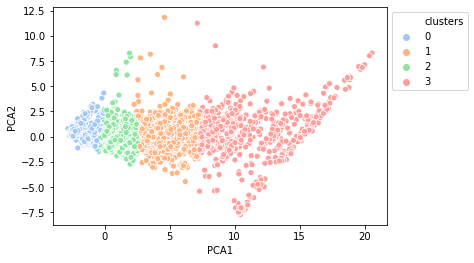

In [49]:
sns.scatterplot(data=PC_DFsubset, x='PCA1', y='PCA2', hue='clusters',
                legend='full', palette=sns.color_palette('pastel', n_colors=4))
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### KMeans, PCA - Visualized Clusters

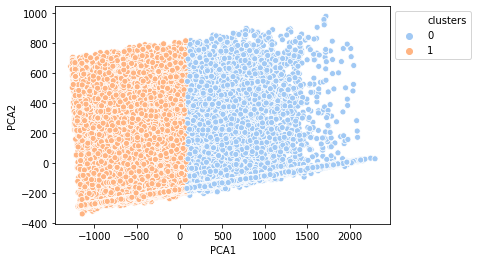

In [50]:
sns.scatterplot(data=principalDf, x='PCA1', y='PCA2', hue='clusters',
                legend='full', palette=sns.color_palette('pastel', n_colors=2))
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### DBSCAN - Visualized Clusters

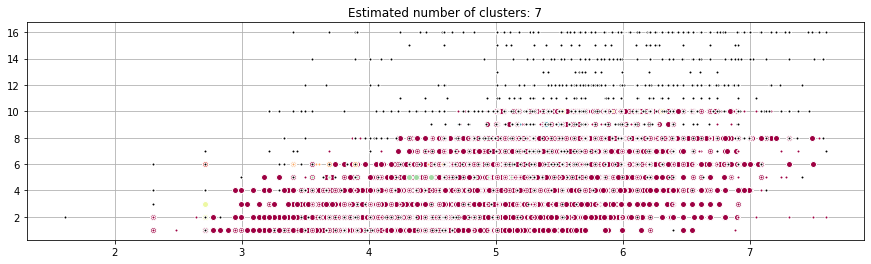

In [51]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

plt.figure(figsize=(15,4))
unique_labels = set(labels) # the unique labels
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
            # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X1[class_member_mask & core_samples_mask]
        # plot the core points in this class
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=6)

        # plot the remaining points that are edge points
    xy = X1[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                markeredgecolor='w', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.grid()
plt.show()

***

## <a id='modeling_evaluation_4'>Modeling and Evaluation 4</a> (20 pts)
[Return to top](#top)

<i><span style='color:gray'>
Summarize the ramifications.
</span></i>

### Interpret KMeans Clusters - PCA

In [52]:
df_explore = df_imputed.copy()
df_explore['clusters'] = clusters
df_explore.head()

,level_0,index,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,price,grade,amenities_new,length_amenities,internet,TV,air_conditioning,kitchen,pool,parking,description_length,superuser,grade_grouped,host_since_days,clusters
0,0,0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,True,True,0.924026,2012-03-26,False,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1,1,150.0,A,"[wireless internet, air conditioning, kitchen,...",9,True,False,True,True,False,False,211,True,A,2179,0
1,1,1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,True,False,1.000000,2017-06-19,True,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3,3,169.0,A,"[wireless internet, air conditioning, kitchen,...",15,True,False,True,True,False,False,1000,False,A,268,1
2,2,2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,True,True,1.000000,2016-10-25,True,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1,3,145.0,A,"[tv, cable tv, wireless internet, air conditio...",19,True,True,True,True,False,False,1000,False,A,505,1
3,3,5,12422935,4.442651,Apartment,Private room,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",2,1.0,Real Bed,strict,True,SF,Beautiful private room overlooking scenic view...,2017-08-27,True,True,1.000000,2017-06-07,True,2017-09-05,37.753164,-122.429526,Comfort Suite San Francisco,Noe Valley,3,100.0,https://a0.muscache.com/im/pictures/82509143-4...,94131,1,1,85.0,A,"[tv, wireless internet, heating, smoke detecto...",10,True,True,False,False,False,False,1000,False,A,280,1
4,4,7,13971273,4.787492,Condominium,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Wheelchair...",2,1.0,Real Bed,moderate,True,LA,Arguably the best location (and safest) in dow...,2016-12-16,True,True,1.000000,2013-05-18,False,2017-04-12,34.046737,-118.260439,"Near LA Live, Staple's. Starbucks inside. OWN ...",Downtown,9,93.0,https://a0.muscache.com/im/pictures/61bd05d5-c...,90015,1,1,120.0,A,"[tv, cable tv, wireless internet, wheelchair a...",26,True,True,False,True,True,True,1000,False,A,1761,0


In [53]:
df_explore['clusters'].value_counts()

1    26961
0    19797
Name: clusters, dtype: int64

In [62]:
df_explore = df_explore.drop(['level_0', 'index', 'property_type', 'id','amenities',
                              'description','zipcode','latitude',
                              'longitude','name','neighbourhood',
                              'review_scores_rating','thumbnail_url',
                               'zipcode', 'amenities_new', 'host_since',
                             'first_review', 'last_review', 'log_price'], axis=1)

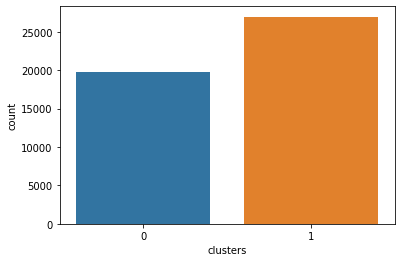

In [63]:
sns.countplot(data=df_explore, x='clusters')
plt.show()

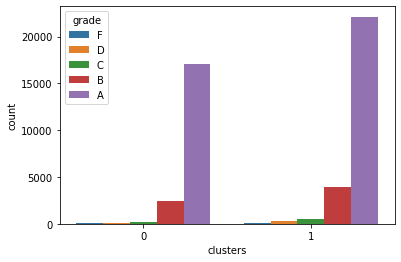

In [64]:
sns.countplot(data=df_explore, x='clusters', hue='grade')
plt.show()

Like what we saw from PCA, grade seems to be represented equally well in both clusters. This implies that our KMeans clusters will not be a good predictor to add to our model

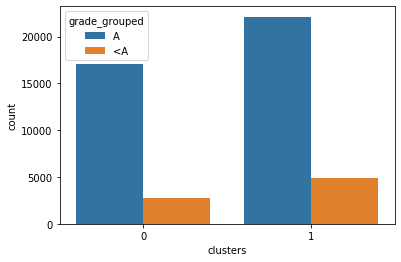

In [65]:
sns.countplot(data=df_explore, x='clusters', hue='grade_grouped')
plt.show()

The same applies for our grade grouped variable

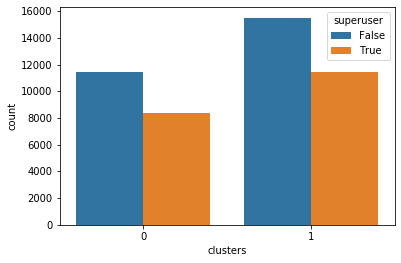

In [66]:
sns.countplot(data=df_explore, x='clusters', hue='superuser')
plt.show()

The same applies for superuser

### Cluster EDA

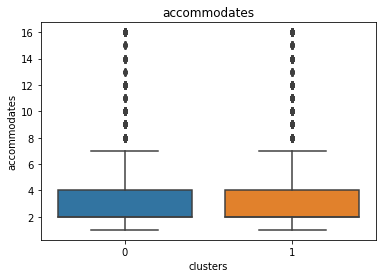

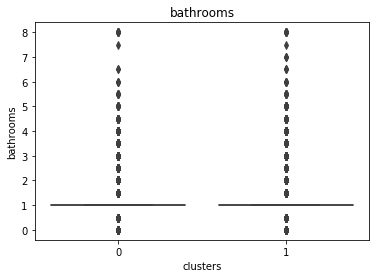

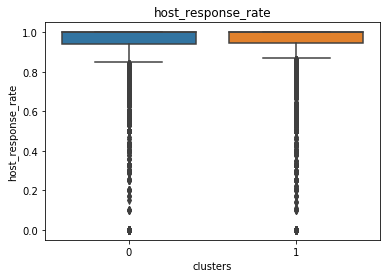

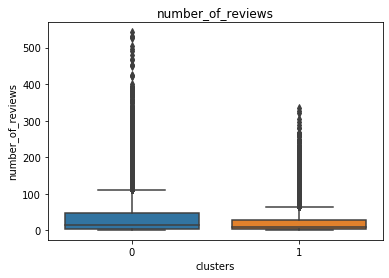

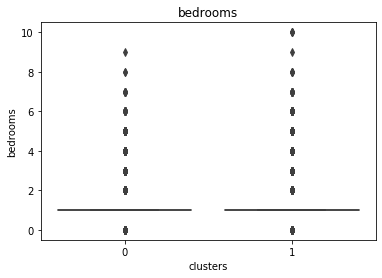

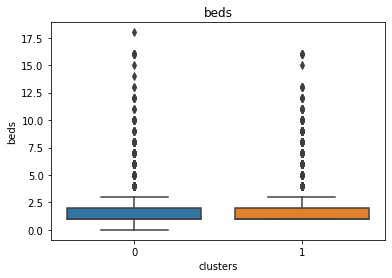

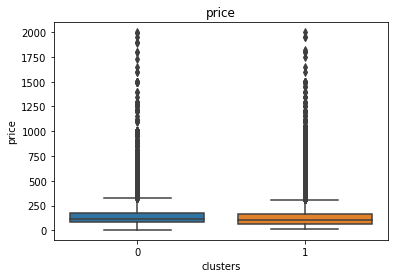

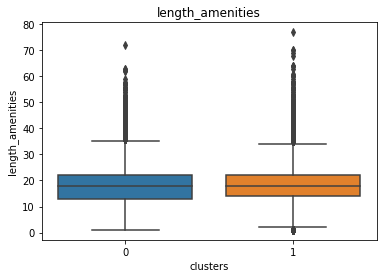

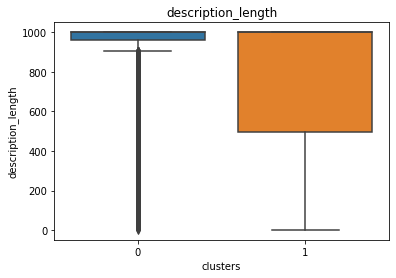

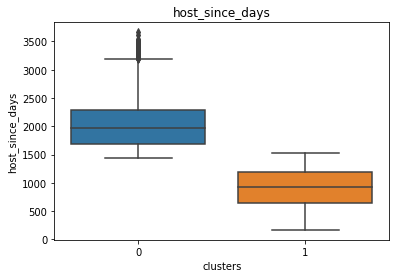

In [67]:
numerics = list(df_explore.select_dtypes(include=['int64', 'float64']).columns)
for x in numerics:
    sns.boxplot(data=df_explore, x='clusters', y=x)
    plt.title(x)
    plt.show()

Cluster 1 seems to include AirBnb users that have been:
    1. longer hosts
    2. have longer description lengths
    3. have more reviews

In [68]:
def make_percent_stacked_boxplot(x):
    '''make a percent stacked barplot where the clusters are the x axis
    and the categorical variable is the y axis'''
    table = pd.crosstab(df_explore['clusters'], df_explore[x], normalize='index')
    table.plot(kind='bar', stacked=True)
    plt.show()

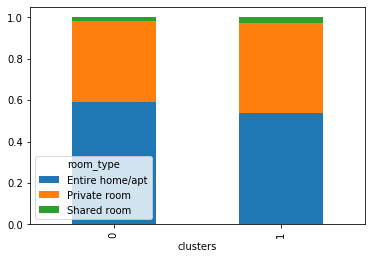

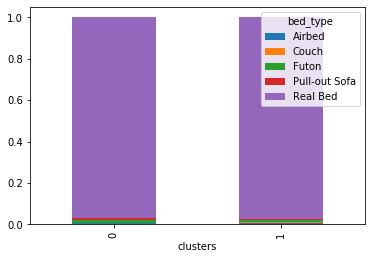

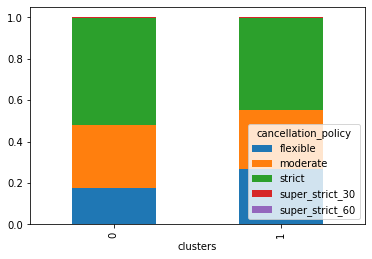

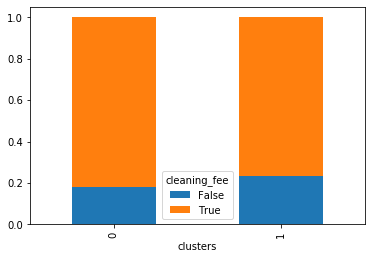

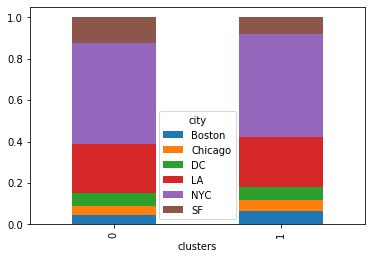

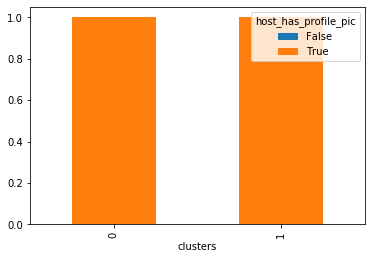

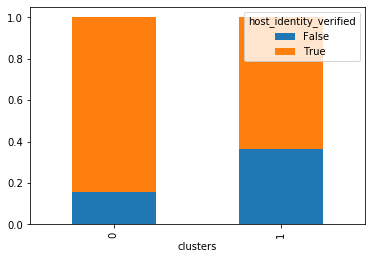

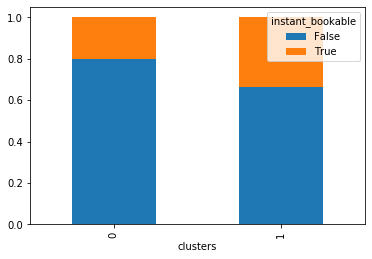

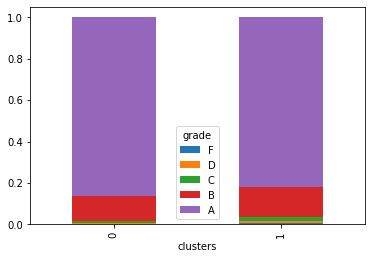

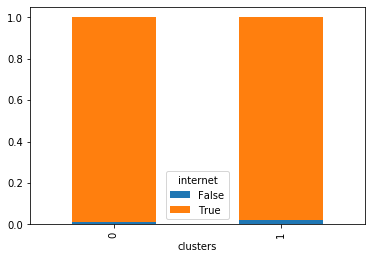

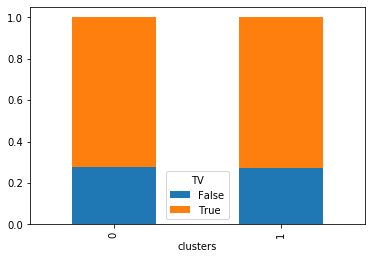

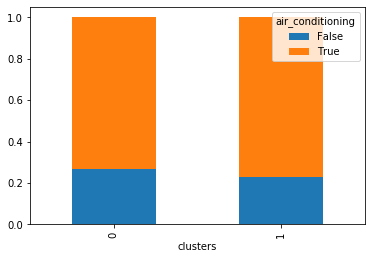

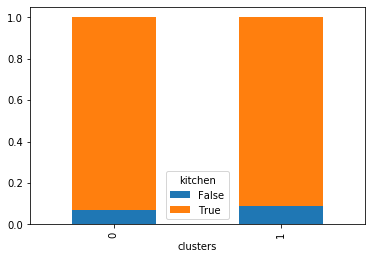

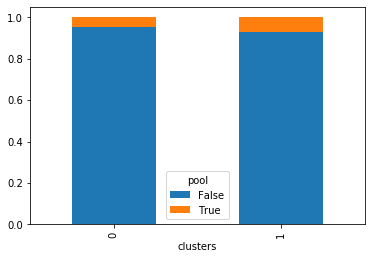

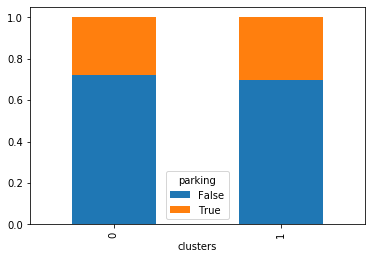

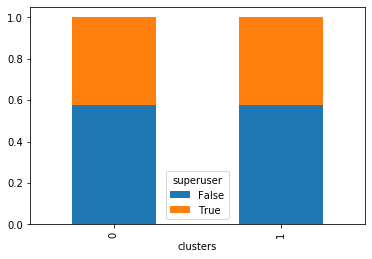

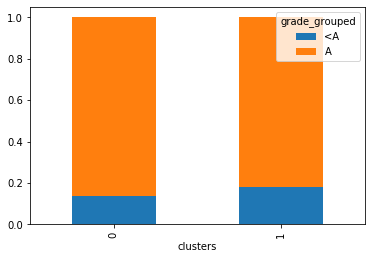

In [69]:
categoricals = list(df_explore.select_dtypes(['object', 'bool', 'category']).columns)
for x in categoricals:
    make_percent_stacked_boxplot(x)

* Our clusters do not seem to seperate out with categorical variables very well
* This makes sense because we could not use categorical variables in the clustering process
    * k-modes method is an alternative clustering method for categorical variables, but there was insufficient documentation 
* The only differences that seem significant is that cluster 1 contains properties that overall are 
    1. less likely to be instant bookable
    2. more likely to have their identity verified
* We also saw that cluster 1 contained hosts that had been using AirBnB for longer, so these may be traits of long time AirBnb users

***

## <a id='deployment'>Deployment</a> (20 pts)
[Return to top](#top)

<i><span style='color:gray'>
Be critical of your performance and tell the reader how your current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it?) How would you deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?
</span></i>

Our use of clustering on the grade-grouped target variable was not very effective. Using the F-test as a measure, we did not see much improvement in our random forest model across 3 methods of clustering, with our best test only yielding a 0.6 improvement in the f-statistic.

This played out visually in our cluster plots, as we saw very little change in distribution between each group. In terms of action, this means that targeting one cluster over another would not likely produce accurate results.

Some useful information was gleaned in examining each cluster; namely, some of the clusters revealed insights into user behavior discussed in section 4. This information could be incorporated into future exercises for more actionable results.


***

## <a id='exceptional_work'>Exceptional Work</a> (10 pts)
[Return to top](#top)

<i><span style='color:gray'>
You have free reign to provide additional analyses or combine analyses.
</span></i>

From the content already in the notebook above, we would like to propose the following for exceptional work credit:

* A
* B
* C

In addition, the below content introduces additional analysis.

### Deriving Cities or Regions from Geographic Coordinates

One natural clustering variable in this dataset is city. In the following code, we demonstrate  that it is possible to recapture the original city labels using the provided geographic coordinates of each listing. While this is a simple thought exercise, it could potentially be expanded into clustering geographically similar regions in a dataset that involves many different Airbnb cities.

In [70]:
# Subset to the coordinates and city labels.
df_coordinates = df.loc[:,['longitude', 'latitude', 'city']]

# Create a numeric city code for use with plt.scatter().
df_cc = pd.Categorical(df_coordinates.city)
df_coordinates['city_codes'] = df_cc.codes

df_coordinates.head()

,longitude,latitude,city,city_codes
0,-73.991617,40.696524,NYC,4
1,-73.989040,40.766115,NYC,4
2,-73.943756,40.808110,NYC,4
3,-122.431619,37.772004,SF,5
4,-77.034596,38.925627,DC,2


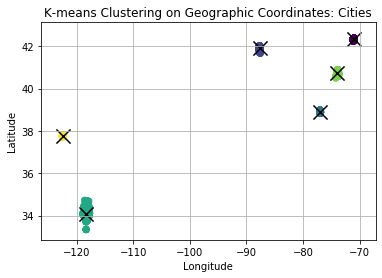

In [71]:
from sklearn.cluster import KMeans

# 6 cities are expected. 
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=1, n_jobs=-1)

# Run clustering algorithm on only coordinates.
kmeans.fit(df_coordinates.loc[:, ['longitude', 'latitude']])

# Visualize coordinates, color-coded by city, with centroids to check clustering.
centroids = kmeans.cluster_centers_
plt.scatter(df_coordinates.loc[:,'longitude'], df_coordinates.loc[:,'latitude'], 
            c=df_coordinates.loc[:,'city_codes'])
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=200, linewidths=3, color='k')
plt.title('K-means Clustering on Geographic Coordinates: Cities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In the above plot, each concentration of colored city points receives one centroid as expected. 

* Two on the West Coast near longitude 120°W for San Francisco and Los Angeles
* One in the Midwest near longitude 90°W for Chicago
* Three along the East Coast between 80°W and 70°W for Washington DC, New York City, and Boston

The idea suggested in the introduction to this section can be implemented by entering a given number of regions to the n_clusters argument instead of the known number of cities. This is demonstrated below, where the graph displays centroids for the three US regions mentioned in the bullet points.

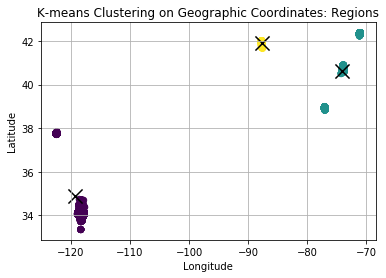

In [72]:
# 3 regions of the US.
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=1, n_jobs=-1)

# Run clustering algorithm on only coordinates.
kmeans.fit(df_coordinates.loc[:, ['longitude', 'latitude']])

# Visualize coordinates, color-coded by k-means cluster labels and centroids.
centroids = kmeans.cluster_centers_
plt.scatter(df_coordinates.loc[:,'longitude'], df_coordinates.loc[:,'latitude'], 
            c=kmeans.labels_)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=200, linewidths=3, color='k')
plt.title('K-means Clustering on Geographic Coordinates: Regions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In [73]:
df_extra = df.loc[:,['log_price', 'accommodates']]

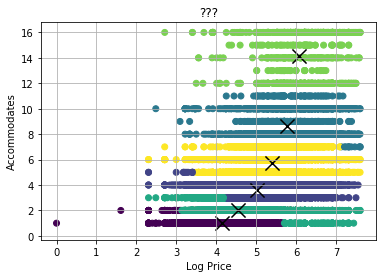

In [74]:
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=3, n_jobs=-1)

# Run clustering algorithm on only coordinates.
kmeans.fit(df_extra)

centroids = kmeans.cluster_centers_
plt.scatter(df_extra.iloc[:, 0], df_extra.iloc[:,1], 
            c=kmeans.labels_)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=200, linewidths=3, color='k')
plt.title('???')
plt.xlabel('Log Price')
plt.ylabel('Accommodates')
plt.grid()
plt.show()